In [ ]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import (
    SigLIPExperiment,
)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
torch.manual_seed(50)

n_classes = 1000
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'


initial_temperature = 10.0
initial_relative_bias = 0.3
bias_is_trainable = False

print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str
)

U_final, V_final, criterion_final, losses_history = experiment.train(
    relative_bias=initial_relative_bias,
    temperature=initial_temperature,
    trainable_bias=bias_is_trainable
)

print("\n--- Training Complete ---")
print(f"Final Loss: {losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=1000, dim=10, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0.3, trainable_bias=False
[100/10000]  loss=0.0065  T=10.3276  rb=0.3000
[200/10000]  loss=0.0047  T=11.1758  rb=0.3000
[300/10000]  loss=0.0036  T=12.5873  rb=0.3000
[400/10000]  loss=0.0028  T=14.5120  rb=0.3000
[500/10000]  loss=0.0021  T=16.9559  rb=0.3000
[600/10000]  loss=0.0015  T=19.8784  rb=0.3000
[700/10000]  loss=0.0010  T=23.1547  rb=0.3000
[800/10000]  loss=0.0007  T=26.5812  rb=0.3000
[900/10000]  loss=0.0005  T=29.9559  rb=0.3000
[1000/10000]  loss=0.0003  T=33.1455  rb=0.3000
[1100/10000]  loss=0.0002  T=36.0921  rb=0.3000
[1200/10000]  loss=0.0002  T=38.7878  rb=0.3000
[1300/10000]  loss=0.0001  T=41.2492  rb=0.3000
[1400/10000]  loss=0.0001  T=43.5019  rb=0.3000
[1500/10000]  loss=0.0001  T=45.5724  rb=0.3000
[1600/10000]  loss=0.0001  T=47.4853  rb=0.3000
[1700/10000]  loss=0.0001  T=49.2621  rb=0.3000
[1800/10000]  loss=0.0000  T=50.9210  rb

<function matplotlib.pyplot.show(close=None, block=None)>

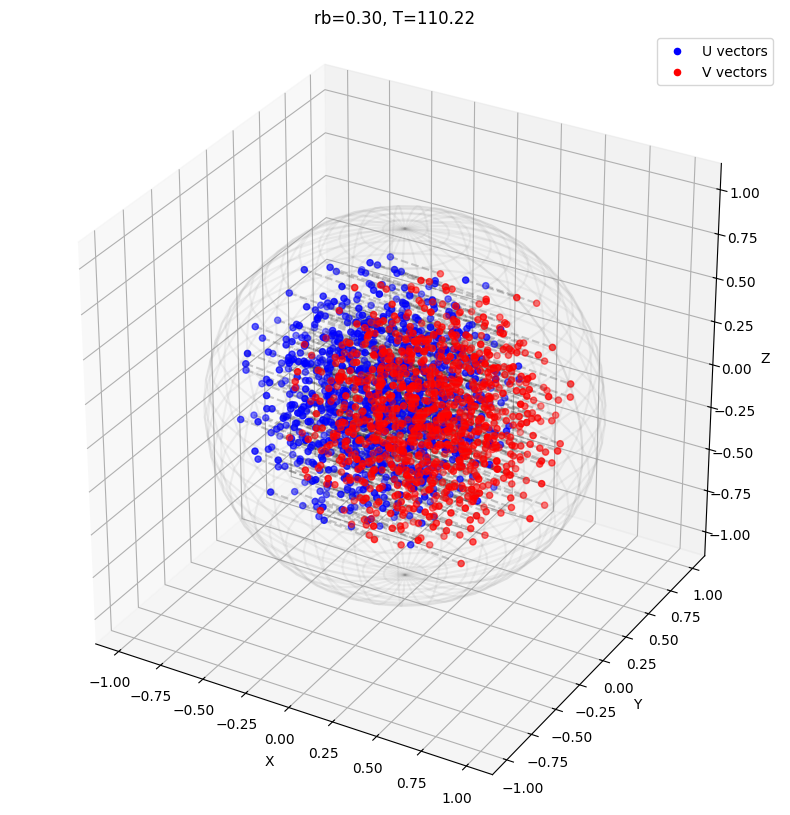

In [65]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show

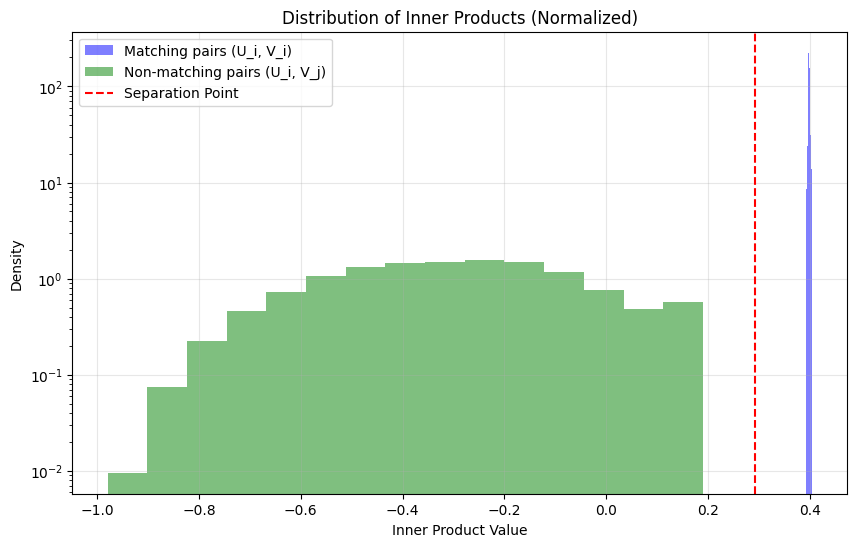

In [87]:
experiment.plot_inner_product_gap(U_final, V_final)

Using device: cpu
Running experiments with: n_classes=100, dim=10, n_epochs=10000
Relative biases to test: [-1.         -0.89473684 -0.78947368 -0.68421053 -0.57894737 -0.47368421
 -0.36842105 -0.26315789 -0.15789474 -0.05263158  0.05263158  0.15789474
  0.26315789  0.36842105  0.47368421  0.57894737  0.68421053  0.78947368
  0.89473684  1.        ]

--- Starting Experiment 1/20 ---
Current Relative Bias: -1.0, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.6998  T=6.6326  rb=-1.0000
[200/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[300/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[400/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[500/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[600/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[700/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[800/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[900/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[1000/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[1100/10000]  loss=0.6931  T=6.6265  rb=-1.0000
[1200/10000]  loss=0.6931  T=6.6

<Figure size 1000x600 with 0 Axes>

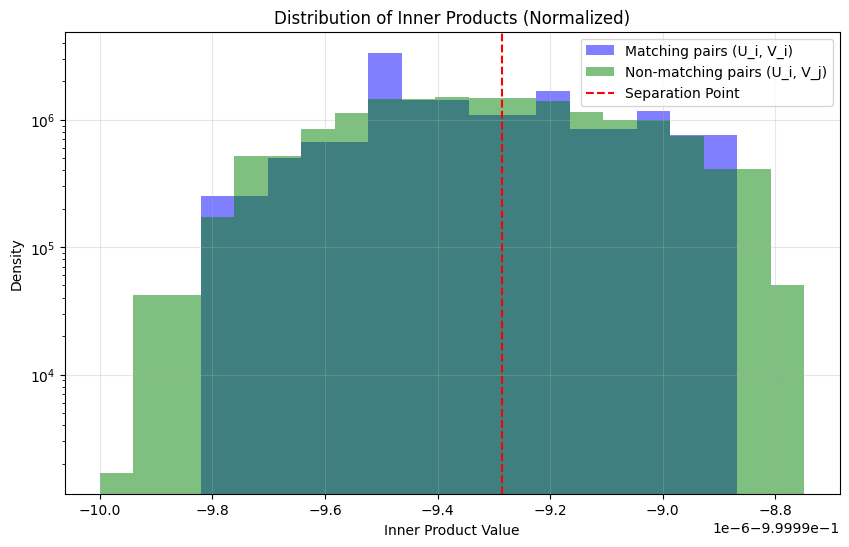


--- Starting Experiment 2/20 ---
Current Relative Bias: -0.8947368421052632, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.4107  T=6.9983  rb=-0.8947
[200/10000]  loss=0.3784  T=7.6325  rb=-0.8947
[300/10000]  loss=0.3486  T=8.6155  rb=-0.8947
[400/10000]  loss=0.3092  T=10.0433  rb=-0.8947
[500/10000]  loss=0.2607  T=12.0647  rb=-0.8947
[600/10000]  loss=0.2068  T=14.8255  rb=-0.8947
[700/10000]  loss=0.1552  T=18.3455  rb=-0.8947
[800/10000]  loss=0.1145  T=22.3831  rb=-0.8947
[900/10000]  loss=0.0878  T=26.4900  rb=-0.8947
[1000/10000]  loss=0.0725  T=30.2572  rb=-0.8947
[1100/10000]  loss=0.0644  T=33.4707  rb=-0.8947
[1200/10000]  loss=0.0602  T=36.0853  rb=-0.8947
[1300/10000]  loss=0.0580  T=38.1448  rb=-0.8947
[1400/10000]  loss=0.0570  T=39.7262  rb=-0.8947
[1500/10000]  loss=0.0560  T=41.0334  rb=-0.8947
[1600/10000]  loss=0.0537  T=42.9660  rb=-0.8947
[1700/10000]  loss=0.0508  T=45.8597  rb=-0.8947
[1800/10000]  loss=0.0476  T=49.4609  rb=-0.8947
[1900/10000]  loss

<Figure size 1000x600 with 0 Axes>

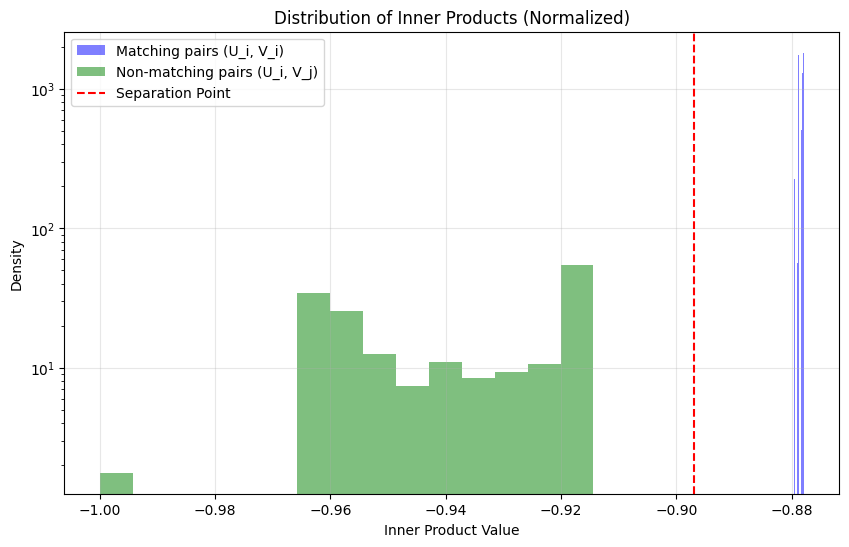


--- Starting Experiment 3/20 ---
Current Relative Bias: -0.7894736842105263, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.2332  T=7.1464  rb=-0.7895
[200/10000]  loss=0.1892  T=7.9576  rb=-0.7895
[300/10000]  loss=0.1570  T=9.0927  rb=-0.7895
[400/10000]  loss=0.1263  T=10.5074  rb=-0.7895
[500/10000]  loss=0.1010  T=12.1059  rb=-0.7895
[600/10000]  loss=0.0829  T=13.7532  rb=-0.7895
[700/10000]  loss=0.0713  T=15.3208  rb=-0.7895
[800/10000]  loss=0.0644  T=16.7221  rb=-0.7895
[900/10000]  loss=0.0605  T=17.9170  rb=-0.7895
[1000/10000]  loss=0.0583  T=18.8996  rb=-0.7895
[1100/10000]  loss=0.0572  T=19.6839  rb=-0.7895
[1200/10000]  loss=0.0566  T=20.2933  rb=-0.7895
[1300/10000]  loss=0.0562  T=20.7555  rb=-0.7895
[1400/10000]  loss=0.0549  T=21.2514  rb=-0.7895
[1500/10000]  loss=0.0523  T=22.3310  rb=-0.7895
[1600/10000]  loss=0.0494  T=23.8911  rb=-0.7895
[1700/10000]  loss=0.0462  T=25.8058  rb=-0.7895
[1800/10000]  loss=0.0426  T=28.0880  rb=-0.7895
[1900/10000]  loss

<Figure size 1000x600 with 0 Axes>

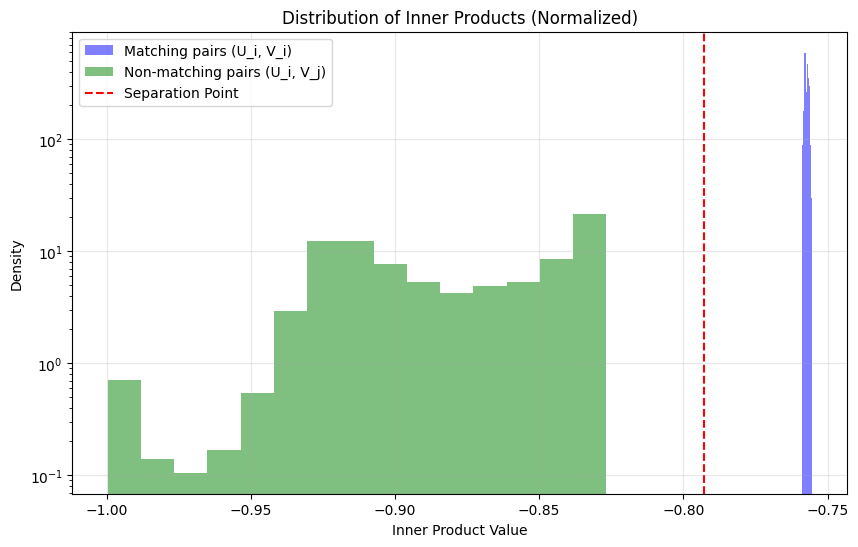


--- Starting Experiment 4/20 ---
Current Relative Bias: -0.6842105263157895, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.1334  T=7.3515  rb=-0.6842
[200/10000]  loss=0.1029  T=8.0635  rb=-0.6842
[300/10000]  loss=0.0868  T=8.9070  rb=-0.6842
[400/10000]  loss=0.0753  T=9.8091  rb=-0.6842
[500/10000]  loss=0.0674  T=10.6955  rb=-0.6842
[600/10000]  loss=0.0624  T=11.5095  rb=-0.6842
[700/10000]  loss=0.0595  T=12.2182  rb=-0.6842
[800/10000]  loss=0.0578  T=12.8093  rb=-0.6842
[900/10000]  loss=0.0569  T=13.2849  rb=-0.6842
[1000/10000]  loss=0.0564  T=13.6618  rb=-0.6842
[1100/10000]  loss=0.0553  T=14.0370  rb=-0.6842
[1200/10000]  loss=0.0534  T=14.6158  rb=-0.6842
[1300/10000]  loss=0.0507  T=15.4900  rb=-0.6842
[1400/10000]  loss=0.0476  T=16.6538  rb=-0.6842
[1500/10000]  loss=0.0441  T=18.0832  rb=-0.6842
[1600/10000]  loss=0.0403  T=19.8047  rb=-0.6842
[1700/10000]  loss=0.0363  T=21.8463  rb=-0.6842
[1800/10000]  loss=0.0321  T=24.2419  rb=-0.6842
[1900/10000]  loss=

<Figure size 1000x600 with 0 Axes>

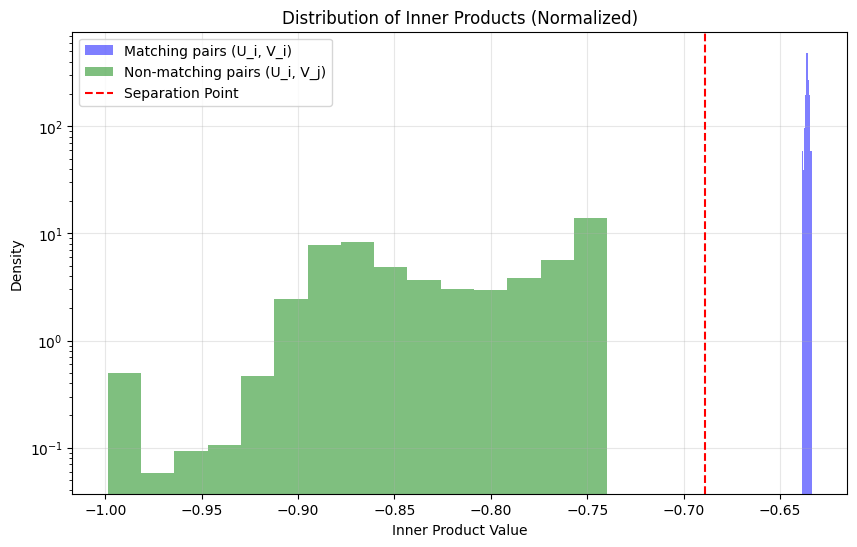


--- Starting Experiment 5/20 ---
Current Relative Bias: -0.5789473684210527, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0875  T=7.4644  rb=-0.5789
[200/10000]  loss=0.0704  T=7.9973  rb=-0.5789
[300/10000]  loss=0.0638  T=8.5333  rb=-0.5789
[400/10000]  loss=0.0602  T=9.0418  rb=-0.5789
[500/10000]  loss=0.0581  T=9.5005  rb=-0.5789
[600/10000]  loss=0.0568  T=9.9017  rb=-0.5789
[700/10000]  loss=0.0557  T=10.2608  rb=-0.5789
[800/10000]  loss=0.0540  T=10.6676  rb=-0.5789
[900/10000]  loss=0.0518  T=11.2282  rb=-0.5789
[1000/10000]  loss=0.0490  T=11.9721  rb=-0.5789
[1100/10000]  loss=0.0459  T=12.9119  rb=-0.5789
[1200/10000]  loss=0.0424  T=14.0581  rb=-0.5789
[1300/10000]  loss=0.0386  T=15.4318  rb=-0.5789
[1400/10000]  loss=0.0346  T=17.0595  rb=-0.5789
[1500/10000]  loss=0.0303  T=18.9694  rb=-0.5789
[1600/10000]  loss=0.0261  T=21.1867  rb=-0.5789
[1700/10000]  loss=0.0218  T=23.7261  rb=-0.5789
[1800/10000]  loss=0.0179  T=26.5776  rb=-0.5789
[1900/10000]  loss=0.

<Figure size 1000x600 with 0 Axes>

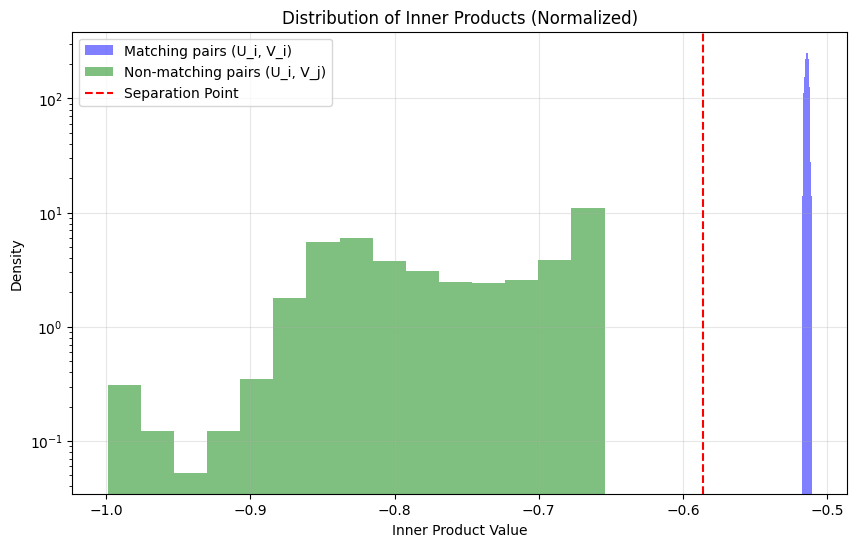


--- Starting Experiment 6/20 ---
Current Relative Bias: -0.4736842105263158, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0661  T=7.6878  rb=-0.4737
[200/10000]  loss=0.0574  T=8.0914  rb=-0.4737
[300/10000]  loss=0.0544  T=8.4632  rb=-0.4737
[400/10000]  loss=0.0524  T=8.8430  rb=-0.4737
[500/10000]  loss=0.0503  T=9.2915  rb=-0.4737
[600/10000]  loss=0.0478  T=9.8577  rb=-0.4737
[700/10000]  loss=0.0450  T=10.5665  rb=-0.4737
[800/10000]  loss=0.0417  T=11.4424  rb=-0.4737
[900/10000]  loss=0.0381  T=12.5115  rb=-0.4737
[1000/10000]  loss=0.0342  T=13.8017  rb=-0.4737
[1100/10000]  loss=0.0300  T=15.3402  rb=-0.4737
[1200/10000]  loss=0.0257  T=17.1500  rb=-0.4737
[1300/10000]  loss=0.0214  T=19.2430  rb=-0.4737
[1400/10000]  loss=0.0174  T=21.6099  rb=-0.4737
[1500/10000]  loss=0.0138  T=24.2112  rb=-0.4737
[1600/10000]  loss=0.0107  T=26.9794  rb=-0.4737
[1700/10000]  loss=0.0083  T=29.8325  rb=-0.4737
[1800/10000]  loss=0.0063  T=32.6906  rb=-0.4737
[1900/10000]  loss=0.

<Figure size 1000x600 with 0 Axes>

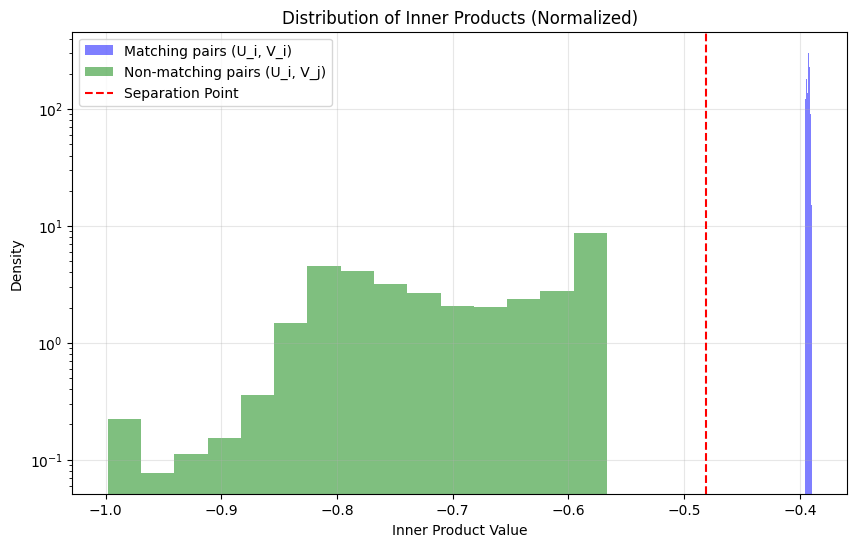


--- Starting Experiment 7/20 ---
Current Relative Bias: -0.368421052631579, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0572  T=7.5352  rb=-0.3684
[200/10000]  loss=0.0513  T=7.8376  rb=-0.3684
[300/10000]  loss=0.0484  T=8.1964  rb=-0.3684
[400/10000]  loss=0.0458  T=8.6596  rb=-0.3684
[500/10000]  loss=0.0430  T=9.2509  rb=-0.3684
[600/10000]  loss=0.0399  T=9.9905  rb=-0.3684
[700/10000]  loss=0.0363  T=10.9015  rb=-0.3684
[800/10000]  loss=0.0325  T=12.0083  rb=-0.3684
[900/10000]  loss=0.0284  T=13.3347  rb=-0.3684
[1000/10000]  loss=0.0242  T=14.8995  rb=-0.3684
[1100/10000]  loss=0.0201  T=16.7099  rb=-0.3684
[1200/10000]  loss=0.0162  T=18.7520  rb=-0.3684
[1300/10000]  loss=0.0127  T=20.9873  rb=-0.3684
[1400/10000]  loss=0.0099  T=23.3551  rb=-0.3684
[1500/10000]  loss=0.0075  T=25.7837  rb=-0.3684
[1600/10000]  loss=0.0058  T=28.2057  rb=-0.3684
[1700/10000]  loss=0.0044  T=30.5678  rb=-0.3684
[1800/10000]  loss=0.0034  T=32.8345  rb=-0.3684
[1900/10000]  loss=0.0

<Figure size 1000x600 with 0 Axes>

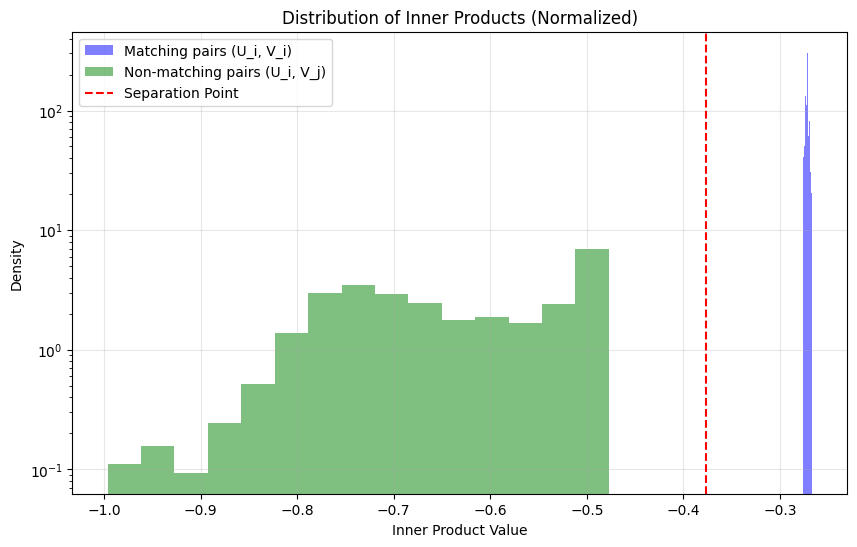


--- Starting Experiment 8/20 ---
Current Relative Bias: -0.26315789473684215, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0512  T=7.8434  rb=-0.2632
[200/10000]  loss=0.0441  T=8.2002  rb=-0.2632
[300/10000]  loss=0.0396  T=8.7805  rb=-0.2632
[400/10000]  loss=0.0356  T=9.5802  rb=-0.2632
[500/10000]  loss=0.0314  T=10.6139  rb=-0.2632
[600/10000]  loss=0.0270  T=11.9112  rb=-0.2632
[700/10000]  loss=0.0223  T=13.4962  rb=-0.2632
[800/10000]  loss=0.0178  T=15.3709  rb=-0.2632
[900/10000]  loss=0.0137  T=17.5045  rb=-0.2632
[1000/10000]  loss=0.0102  T=19.8270  rb=-0.2632
[1100/10000]  loss=0.0075  T=22.2398  rb=-0.2632
[1200/10000]  loss=0.0055  T=24.6476  rb=-0.2632
[1300/10000]  loss=0.0041  T=26.9809  rb=-0.2632
[1400/10000]  loss=0.0031  T=29.1991  rb=-0.2632
[1500/10000]  loss=0.0023  T=31.2845  rb=-0.2632
[1600/10000]  loss=0.0018  T=33.2338  rb=-0.2632
[1700/10000]  loss=0.0014  T=35.0529  rb=-0.2632
[1800/10000]  loss=0.0011  T=36.7512  rb=-0.2632
[1900/10000]  loss

<Figure size 1000x600 with 0 Axes>

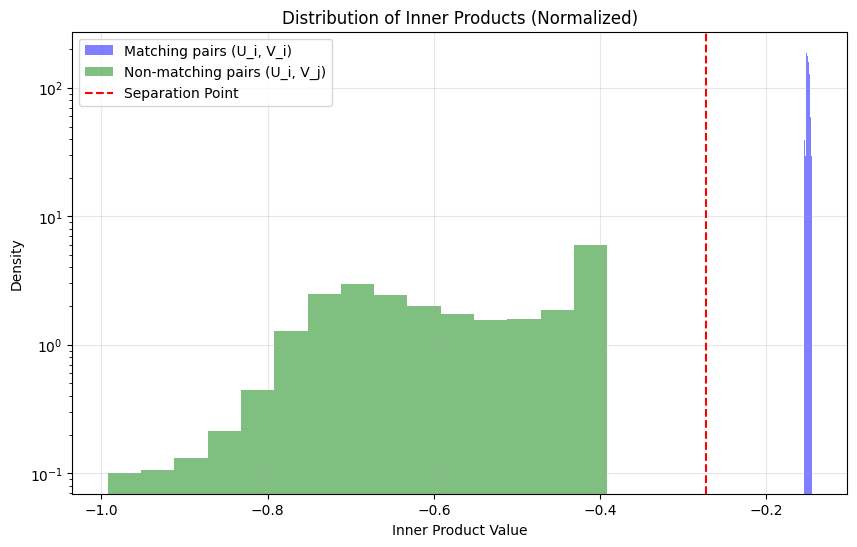


--- Starting Experiment 9/20 ---
Current Relative Bias: -0.1578947368421053, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0470  T=7.7113  rb=-0.1579
[200/10000]  loss=0.0384  T=8.1584  rb=-0.1579
[300/10000]  loss=0.0335  T=8.9207  rb=-0.1579
[400/10000]  loss=0.0289  T=9.9543  rb=-0.1579
[500/10000]  loss=0.0241  T=11.2832  rb=-0.1579
[600/10000]  loss=0.0192  T=12.9233  rb=-0.1579
[700/10000]  loss=0.0146  T=14.8595  rb=-0.1579
[800/10000]  loss=0.0107  T=17.0257  rb=-0.1579
[900/10000]  loss=0.0077  T=19.3148  rb=-0.1579
[1000/10000]  loss=0.0055  T=21.6163  rb=-0.1579
[1100/10000]  loss=0.0040  T=23.8453  rb=-0.1579
[1200/10000]  loss=0.0029  T=25.9520  rb=-0.1579
[1300/10000]  loss=0.0022  T=27.9164  rb=-0.1579
[1400/10000]  loss=0.0016  T=29.7371  rb=-0.1579
[1500/10000]  loss=0.0013  T=31.4225  rb=-0.1579
[1600/10000]  loss=0.0010  T=32.9850  rb=-0.1579
[1700/10000]  loss=0.0008  T=34.4377  rb=-0.1579
[1800/10000]  loss=0.0007  T=35.7930  rb=-0.1579
[1900/10000]  loss=

<Figure size 1000x600 with 0 Axes>

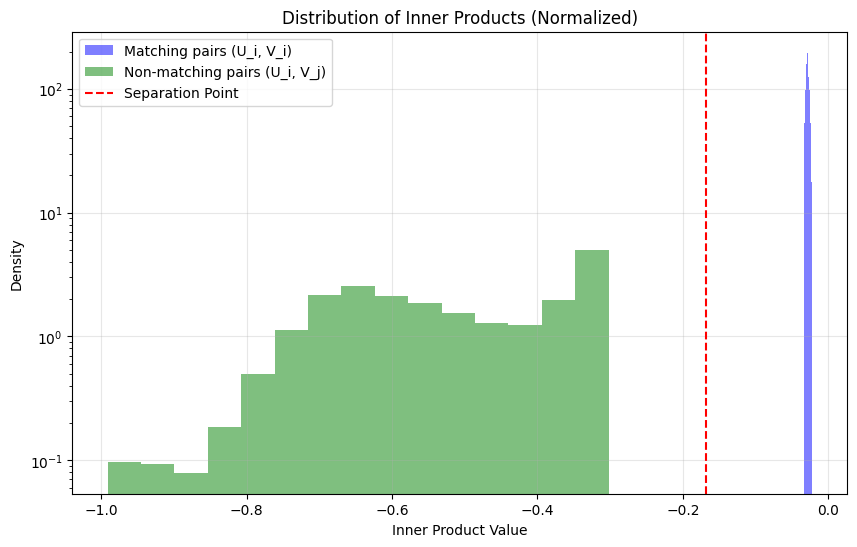


--- Starting Experiment 10/20 ---
Current Relative Bias: -0.052631578947368474, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0402  T=7.9931  rb=-0.0526
[200/10000]  loss=0.0302  T=8.8547  rb=-0.0526
[300/10000]  loss=0.0237  T=10.2454  rb=-0.0526
[400/10000]  loss=0.0176  T=12.1193  rb=-0.0526
[500/10000]  loss=0.0122  T=14.4235  rb=-0.0526
[600/10000]  loss=0.0081  T=16.9965  rb=-0.0526
[700/10000]  loss=0.0052  T=19.6219  rb=-0.0526
[800/10000]  loss=0.0034  T=22.1307  rb=-0.0526
[900/10000]  loss=0.0023  T=24.4400  rb=-0.0526
[1000/10000]  loss=0.0016  T=26.5318  rb=-0.0526
[1100/10000]  loss=0.0012  T=28.4195  rb=-0.0526
[1200/10000]  loss=0.0009  T=30.1274  rb=-0.0526
[1300/10000]  loss=0.0007  T=31.6808  rb=-0.0526
[1400/10000]  loss=0.0005  T=33.1025  rb=-0.0526
[1500/10000]  loss=0.0004  T=34.4122  rb=-0.0526
[1600/10000]  loss=0.0004  T=35.6261  rb=-0.0526
[1700/10000]  loss=0.0003  T=36.7579  rb=-0.0526
[1800/10000]  loss=0.0002  T=37.8187  rb=-0.0526
[1900/10000]  

<Figure size 1000x600 with 0 Axes>

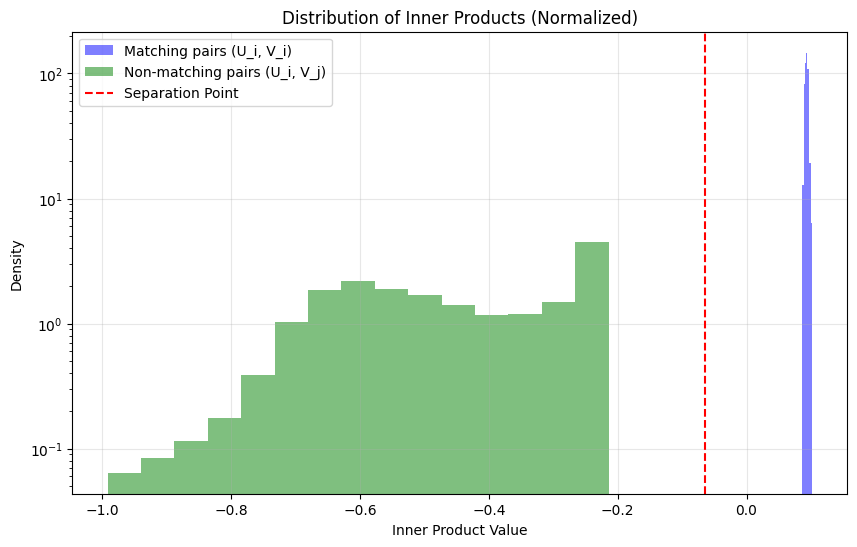


--- Starting Experiment 11/20 ---
Current Relative Bias: 0.05263157894736836, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0328  T=8.3854  rb=0.0526
[200/10000]  loss=0.0219  T=9.9279  rb=0.0526
[300/10000]  loss=0.0144  T=12.1909  rb=0.0526
[400/10000]  loss=0.0088  T=14.9925  rb=0.0526
[500/10000]  loss=0.0051  T=17.9746  rb=0.0526
[600/10000]  loss=0.0030  T=20.8066  rb=0.0526
[700/10000]  loss=0.0019  T=23.3436  rb=0.0526
[800/10000]  loss=0.0013  T=25.5731  rb=0.0526
[900/10000]  loss=0.0009  T=27.5317  rb=0.0526
[1000/10000]  loss=0.0006  T=29.2643  rb=0.0526
[1100/10000]  loss=0.0005  T=30.8118  rb=0.0526
[1200/10000]  loss=0.0004  T=32.2080  rb=0.0526
[1300/10000]  loss=0.0003  T=33.4792  rb=0.0526
[1400/10000]  loss=0.0002  T=34.6467  rb=0.0526
[1500/10000]  loss=0.0002  T=35.7270  rb=0.0526
[1600/10000]  loss=0.0002  T=36.7331  rb=0.0526
[1700/10000]  loss=0.0001  T=37.6755  rb=0.0526
[1800/10000]  loss=0.0001  T=38.5630  rb=0.0526
[1900/10000]  loss=0.0001  T=39.40

<Figure size 1000x600 with 0 Axes>

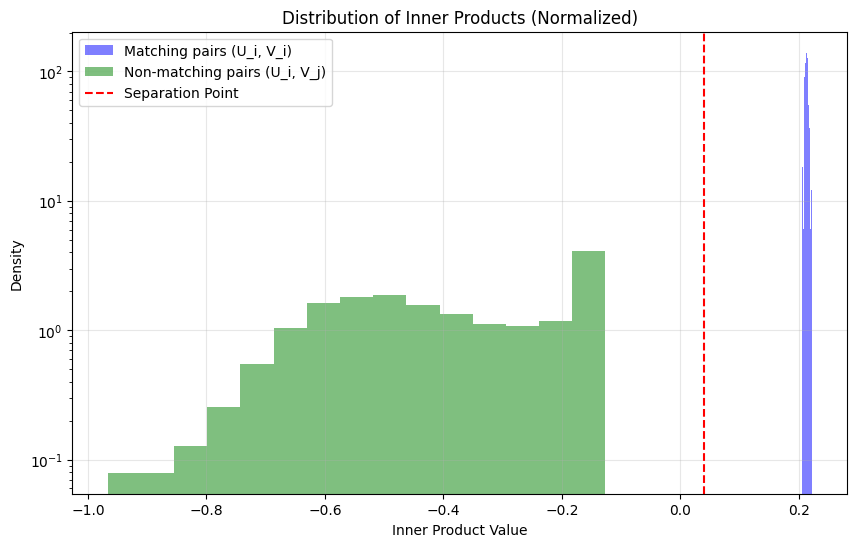


--- Starting Experiment 12/20 ---
Current Relative Bias: 0.1578947368421053, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0271  T=8.6763  rb=0.1579
[200/10000]  loss=0.0144  T=11.3421  rb=0.1579
[300/10000]  loss=0.0071  T=14.9332  rb=0.1579
[400/10000]  loss=0.0034  T=18.5999  rb=0.1579
[500/10000]  loss=0.0018  T=21.8010  rb=0.1579
[600/10000]  loss=0.0010  T=24.4648  rb=0.1579
[700/10000]  loss=0.0007  T=26.6898  rb=0.1579
[800/10000]  loss=0.0005  T=28.5812  rb=0.1579
[900/10000]  loss=0.0003  T=30.2195  rb=0.1579
[1000/10000]  loss=0.0002  T=31.6630  rb=0.1579
[1100/10000]  loss=0.0002  T=32.9531  rb=0.1579
[1200/10000]  loss=0.0001  T=34.1204  rb=0.1579
[1300/10000]  loss=0.0001  T=35.1874  rb=0.1579
[1400/10000]  loss=0.0001  T=36.1711  rb=0.1579
[1500/10000]  loss=0.0001  T=37.0847  rb=0.1579
[1600/10000]  loss=0.0001  T=37.9387  rb=0.1579
[1700/10000]  loss=0.0001  T=38.7415  rb=0.1579
[1800/10000]  loss=0.0000  T=39.4997  rb=0.1579
[1900/10000]  loss=0.0000  T=40.21

<Figure size 1000x600 with 0 Axes>

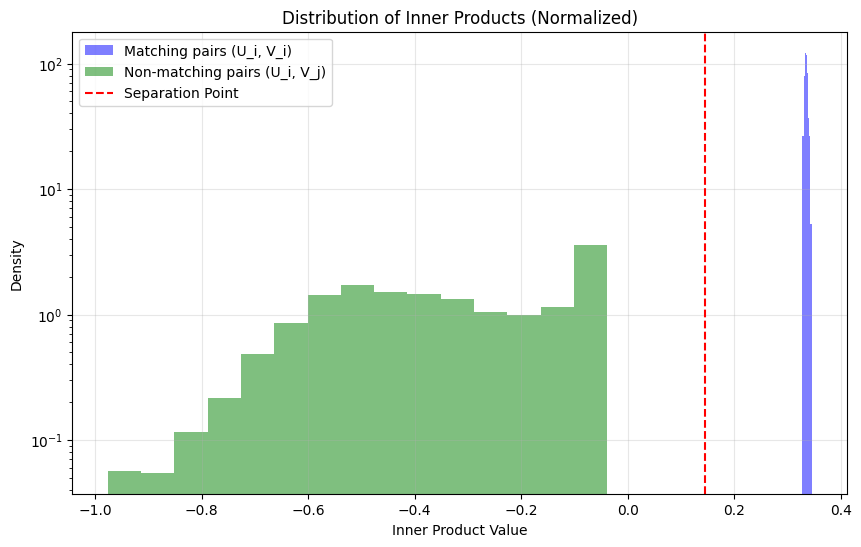


--- Starting Experiment 13/20 ---
Current Relative Bias: 0.26315789473684204, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0154  T=11.0064  rb=0.2632
[200/10000]  loss=0.0044  T=16.3990  rb=0.2632
[300/10000]  loss=0.0015  T=21.1416  rb=0.2632
[400/10000]  loss=0.0007  T=24.6653  rb=0.2632
[500/10000]  loss=0.0004  T=27.3490  rb=0.2632
[600/10000]  loss=0.0002  T=29.4923  rb=0.2632
[700/10000]  loss=0.0002  T=31.2715  rb=0.2632
[800/10000]  loss=0.0001  T=32.7921  rb=0.2632
[900/10000]  loss=0.0001  T=34.1211  rb=0.2632
[1000/10000]  loss=0.0001  T=35.3030  rb=0.2632
[1100/10000]  loss=0.0001  T=36.3688  rb=0.2632
[1200/10000]  loss=0.0000  T=37.3410  rb=0.2632
[1300/10000]  loss=0.0000  T=38.2360  rb=0.2632
[1400/10000]  loss=0.0000  T=39.0667  rb=0.2632
[1500/10000]  loss=0.0000  T=39.8428  rb=0.2632
[1600/10000]  loss=0.0000  T=40.5721  rb=0.2632
[1700/10000]  loss=0.0000  T=41.2611  rb=0.2632
[1800/10000]  loss=0.0000  T=41.9146  rb=0.2632
[1900/10000]  loss=0.0000  T=42.

<Figure size 1000x600 with 0 Axes>

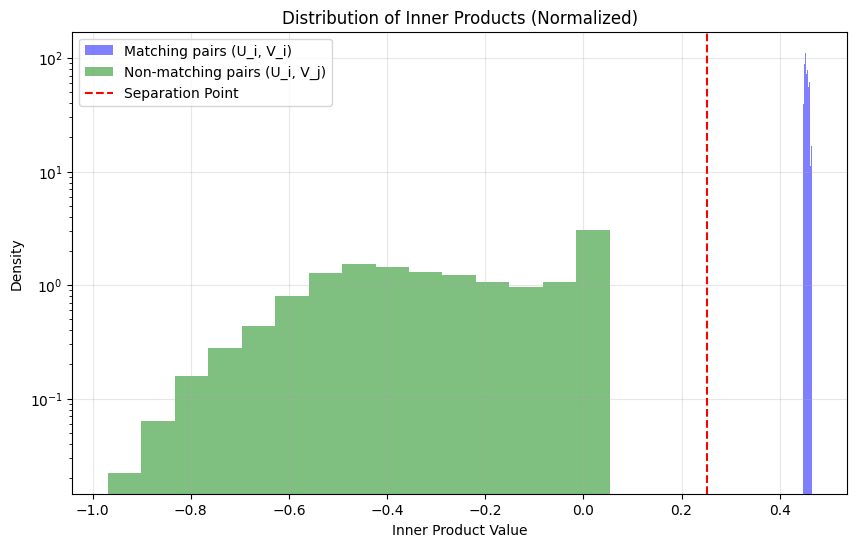


--- Starting Experiment 14/20 ---
Current Relative Bias: 0.36842105263157876, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0068  T=15.8636  rb=0.3684
[200/10000]  loss=0.0014  T=21.3617  rb=0.3684
[300/10000]  loss=0.0005  T=24.8723  rb=0.3684
[400/10000]  loss=0.0003  T=27.4160  rb=0.3684
[500/10000]  loss=0.0002  T=29.4139  rb=0.3684
[600/10000]  loss=0.0001  T=31.0613  rb=0.3684
[700/10000]  loss=0.0001  T=32.4647  rb=0.3684
[800/10000]  loss=0.0001  T=33.6887  rb=0.3684
[900/10000]  loss=0.0000  T=34.7757  rb=0.3684
[1000/10000]  loss=0.0000  T=35.7548  rb=0.3684
[1100/10000]  loss=0.0000  T=36.6469  rb=0.3684
[1200/10000]  loss=0.0000  T=37.4675  rb=0.3684
[1300/10000]  loss=0.0000  T=38.2283  rb=0.3684
[1400/10000]  loss=0.0000  T=38.9385  rb=0.3684
[1500/10000]  loss=0.0000  T=39.6053  rb=0.3684
[1600/10000]  loss=0.0000  T=40.2348  rb=0.3684
[1700/10000]  loss=0.0000  T=40.8315  rb=0.3684
[1800/10000]  loss=0.0000  T=41.3995  rb=0.3684
[1900/10000]  loss=0.0000  T=41.

<Figure size 1000x600 with 0 Axes>

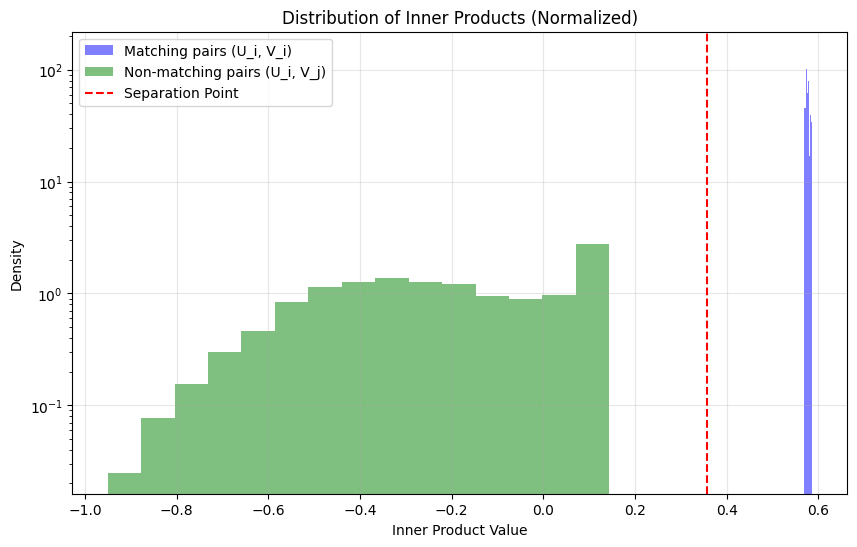


--- Starting Experiment 15/20 ---
Current Relative Bias: 0.4736842105263157, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0026  T=18.5850  rb=0.4737
[200/10000]  loss=0.0005  T=24.0802  rb=0.4737
[300/10000]  loss=0.0002  T=27.2701  rb=0.4737
[400/10000]  loss=0.0001  T=29.5376  rb=0.4737
[500/10000]  loss=0.0001  T=31.3068  rb=0.4737
[600/10000]  loss=0.0000  T=32.7625  rb=0.4737
[700/10000]  loss=0.0000  T=34.0024  rb=0.4737
[800/10000]  loss=0.0000  T=35.0851  rb=0.4737
[900/10000]  loss=0.0000  T=36.0482  rb=0.4737
[1000/10000]  loss=0.0000  T=36.9174  rb=0.4737
[1100/10000]  loss=0.0000  T=37.7109  rb=0.4737
[1200/10000]  loss=0.0000  T=38.4424  rb=0.4737
[1300/10000]  loss=0.0000  T=39.1219  rb=0.4737
[1400/10000]  loss=0.0000  T=39.7575  rb=0.4737
[1500/10000]  loss=0.0000  T=40.3555  rb=0.4737
[1600/10000]  loss=0.0000  T=40.9209  rb=0.4737
[1700/10000]  loss=0.0000  T=41.4578  rb=0.4737
[1800/10000]  loss=0.0000  T=41.9697  rb=0.4737
[1900/10000]  loss=0.0000  T=42.4

<Figure size 1000x600 with 0 Axes>

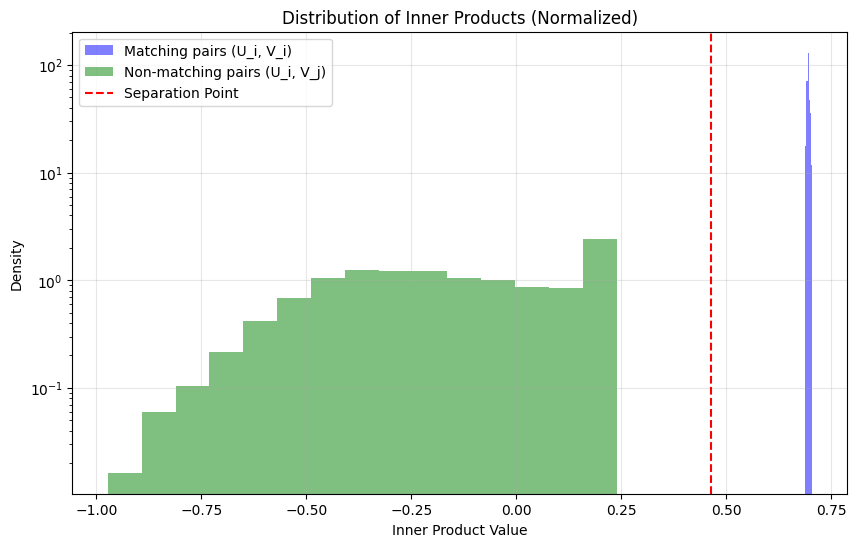


--- Starting Experiment 16/20 ---
Current Relative Bias: 0.5789473684210527, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0016  T=19.6149  rb=0.5789
[200/10000]  loss=0.0004  T=24.8777  rb=0.5789
[300/10000]  loss=0.0002  T=28.0629  rb=0.5789
[400/10000]  loss=0.0001  T=30.3430  rb=0.5789
[500/10000]  loss=0.0001  T=32.1195  rb=0.5789
[600/10000]  loss=0.0000  T=33.5770  rb=0.5789
[700/10000]  loss=0.0000  T=34.8150  rb=0.5789
[800/10000]  loss=0.0000  T=35.8933  rb=0.5789
[900/10000]  loss=0.0000  T=36.8504  rb=0.5789
[1000/10000]  loss=0.0000  T=37.7124  rb=0.5789
[1100/10000]  loss=0.0000  T=38.4981  rb=0.5789
[1200/10000]  loss=0.0000  T=39.2211  rb=0.5789
[1300/10000]  loss=0.0000  T=39.8919  rb=0.5789
[1400/10000]  loss=0.0000  T=40.5184  rb=0.5789
[1500/10000]  loss=0.0000  T=41.1071  rb=0.5789
[1600/10000]  loss=0.0000  T=41.6631  rb=0.5789
[1700/10000]  loss=0.0000  T=42.1905  rb=0.5789
[1800/10000]  loss=0.0000  T=42.6928  rb=0.5789
[1900/10000]  loss=0.0000  T=43.1

<Figure size 1000x600 with 0 Axes>

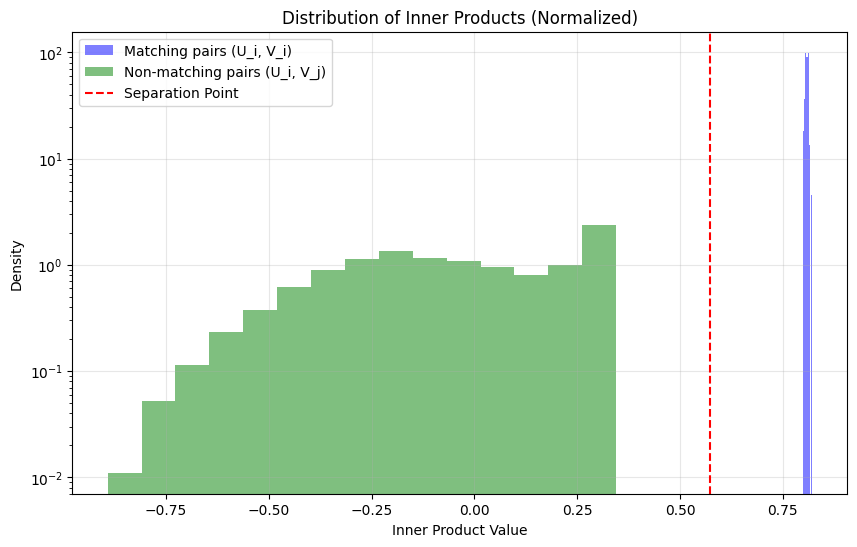


--- Starting Experiment 17/20 ---
Current Relative Bias: 0.6842105263157894, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0013  T=17.4689  rb=0.6842
[200/10000]  loss=0.0003  T=22.0029  rb=0.6842
[300/10000]  loss=0.0001  T=24.7028  rb=0.6842
[400/10000]  loss=0.0001  T=26.6291  rb=0.6842
[500/10000]  loss=0.0000  T=28.1290  rb=0.6842
[600/10000]  loss=0.0000  T=29.3592  rb=0.6842
[700/10000]  loss=0.0000  T=30.4039  rb=0.6842
[800/10000]  loss=0.0000  T=31.3137  rb=0.6842
[900/10000]  loss=0.0000  T=32.1211  rb=0.6842
[1000/10000]  loss=0.0000  T=32.8480  rb=0.6842
[1100/10000]  loss=0.0000  T=33.5105  rb=0.6842
[1200/10000]  loss=0.0000  T=34.1199  rb=0.6842
[1300/10000]  loss=0.0000  T=34.6852  rb=0.6842
[1400/10000]  loss=0.0000  T=35.2130  rb=0.6842
[1500/10000]  loss=0.0000  T=35.7090  rb=0.6842
[1600/10000]  loss=0.0000  T=36.1773  rb=0.6842
[1700/10000]  loss=0.0000  T=36.6215  rb=0.6842
[1800/10000]  loss=0.0000  T=37.0445  rb=0.6842
[1900/10000]  loss=0.0000  T=37.4

<Figure size 1000x600 with 0 Axes>

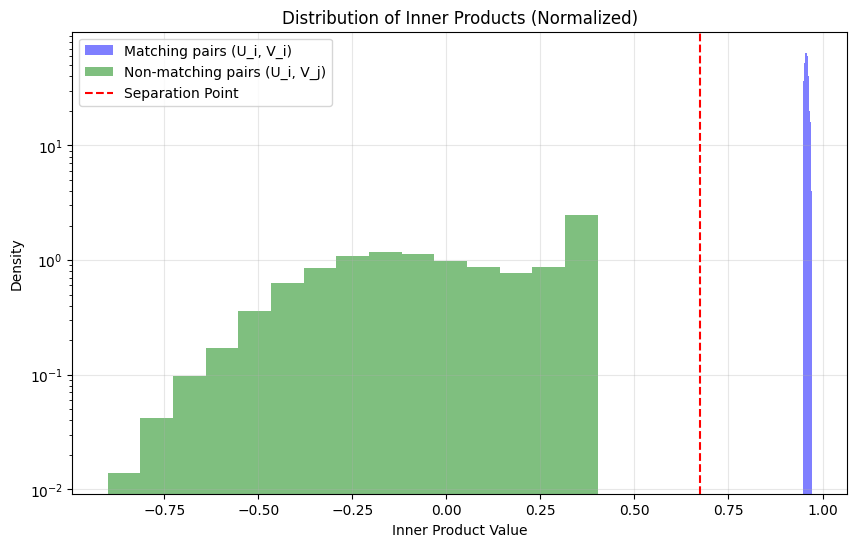


--- Starting Experiment 18/20 ---
Current Relative Bias: 0.7894736842105261, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0014  T=14.7785  rb=0.7895
[200/10000]  loss=0.0004  T=18.7474  rb=0.7895
[300/10000]  loss=0.0002  T=21.1855  rb=0.7895
[400/10000]  loss=0.0001  T=23.0344  rb=0.7895
[500/10000]  loss=0.0001  T=24.5614  rb=0.7895
[600/10000]  loss=0.0001  T=25.8801  rb=0.7895
[700/10000]  loss=0.0000  T=27.0506  rb=0.7895
[800/10000]  loss=0.0000  T=28.1089  rb=0.7895
[900/10000]  loss=0.0000  T=29.0788  rb=0.7895
[1000/10000]  loss=0.0000  T=29.9769  rb=0.7895
[1100/10000]  loss=0.0000  T=30.8152  rb=0.7895
[1200/10000]  loss=0.0000  T=31.6029  rb=0.7895
[1300/10000]  loss=0.0000  T=32.3471  rb=0.7895
[1400/10000]  loss=0.0000  T=33.0535  rb=0.7895
[1500/10000]  loss=0.0000  T=33.7267  rb=0.7895
[1600/10000]  loss=0.0000  T=34.3706  rb=0.7895
[1700/10000]  loss=0.0000  T=34.9882  rb=0.7895
[1800/10000]  loss=0.0000  T=35.5824  rb=0.7895
[1900/10000]  loss=0.0000  T=36.1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Figure size 1000x600 with 0 Axes>

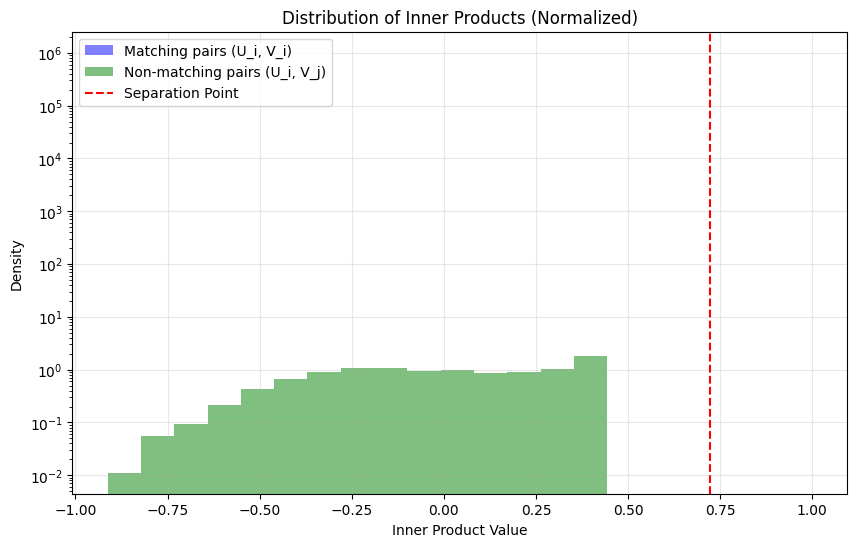


--- Starting Experiment 19/20 ---
Current Relative Bias: 0.894736842105263, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0035  T=11.7265  rb=0.8947
[200/10000]  loss=0.0019  T=15.6307  rb=0.8947
[300/10000]  loss=0.0012  T=19.3823  rb=0.8947
[400/10000]  loss=0.0008  T=23.5358  rb=0.8947
[500/10000]  loss=0.0005  T=27.9871  rb=0.8947
[600/10000]  loss=0.0003  T=32.4183  rb=0.8947
[700/10000]  loss=0.0002  T=36.5798  rb=0.8947
[800/10000]  loss=0.0001  T=40.3673  rb=0.8947
[900/10000]  loss=0.0001  T=43.7742  rb=0.8947
[1000/10000]  loss=0.0001  T=46.8359  rb=0.8947
[1100/10000]  loss=0.0001  T=49.5990  rb=0.8947
[1200/10000]  loss=0.0000  T=52.1084  rb=0.8947
[1300/10000]  loss=0.0000  T=54.4031  rb=0.8947
[1400/10000]  loss=0.0000  T=56.5159  rb=0.8947
[1500/10000]  loss=0.0000  T=58.4731  rb=0.8947
[1600/10000]  loss=0.0000  T=60.2973  rb=0.8947
[1700/10000]  loss=0.0000  T=62.0061  rb=0.8947
[1800/10000]  loss=0.0000  T=63.6150  rb=0.8947
[1900/10000]  loss=0.0000  T=65.13

<Figure size 1000x600 with 0 Axes>

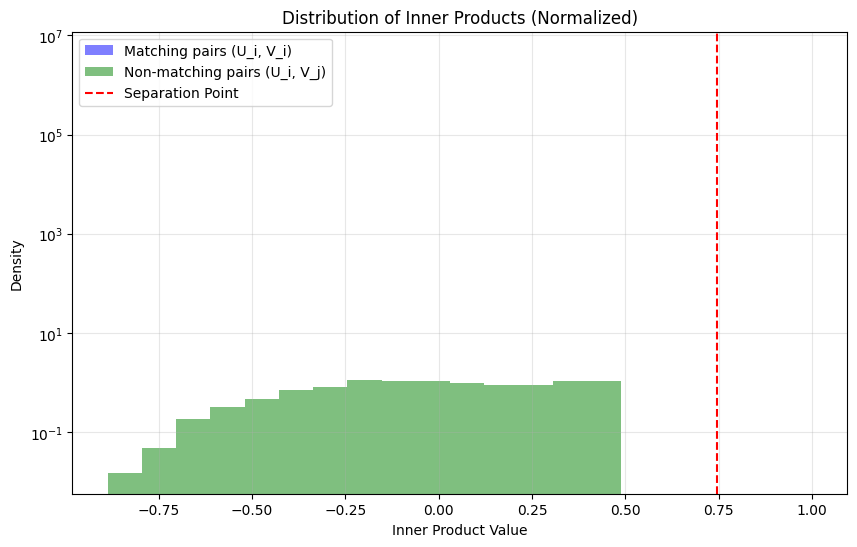


--- Starting Experiment 20/20 ---
Current Relative Bias: 1.0, Trainable Bias: False, Temp: 10.0
[100/10000]  loss=0.0079  T=9.5985  rb=1.0000
[200/10000]  loss=0.0072  T=11.3834  rb=1.0000
[300/10000]  loss=0.0071  T=12.5289  rb=1.0000
[400/10000]  loss=0.0070  T=13.3754  rb=1.0000
[500/10000]  loss=0.0070  T=14.0477  rb=1.0000
[600/10000]  loss=0.0070  T=14.6062  rb=1.0000
[700/10000]  loss=0.0070  T=15.0849  rb=1.0000
[800/10000]  loss=0.0070  T=15.5045  rb=1.0000
[900/10000]  loss=0.0069  T=15.8788  rb=1.0000
[1000/10000]  loss=0.0069  T=16.2172  rb=1.0000
[1100/10000]  loss=0.0069  T=16.5267  rb=1.0000
[1200/10000]  loss=0.0069  T=16.8122  rb=1.0000
[1300/10000]  loss=0.0069  T=17.0777  rb=1.0000
[1400/10000]  loss=0.0069  T=17.3262  rb=1.0000
[1500/10000]  loss=0.0069  T=17.5600  rb=1.0000
[1600/10000]  loss=0.0069  T=17.7813  rb=1.0000
[1700/10000]  loss=0.0069  T=17.9914  rb=1.0000
[1800/10000]  loss=0.0069  T=18.1918  rb=1.0000
[1900/10000]  loss=0.0069  T=18.3836  rb=1.0000
[

<Figure size 1000x600 with 0 Axes>

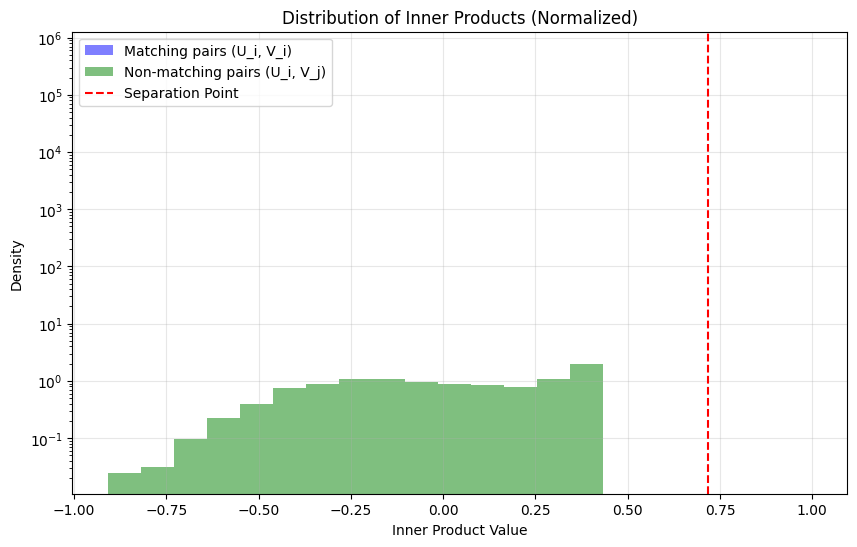


--- All Experiments Complete. Analyzing and Plotting Aggregate Results. ---


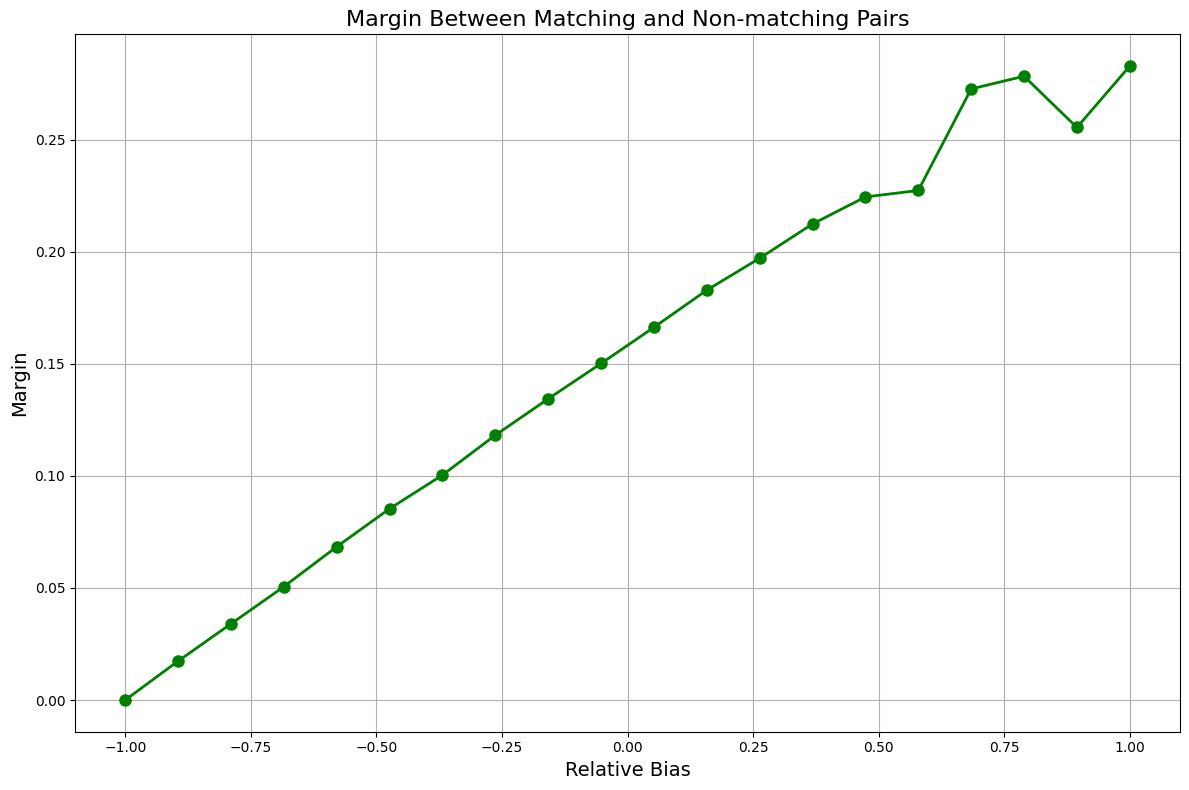

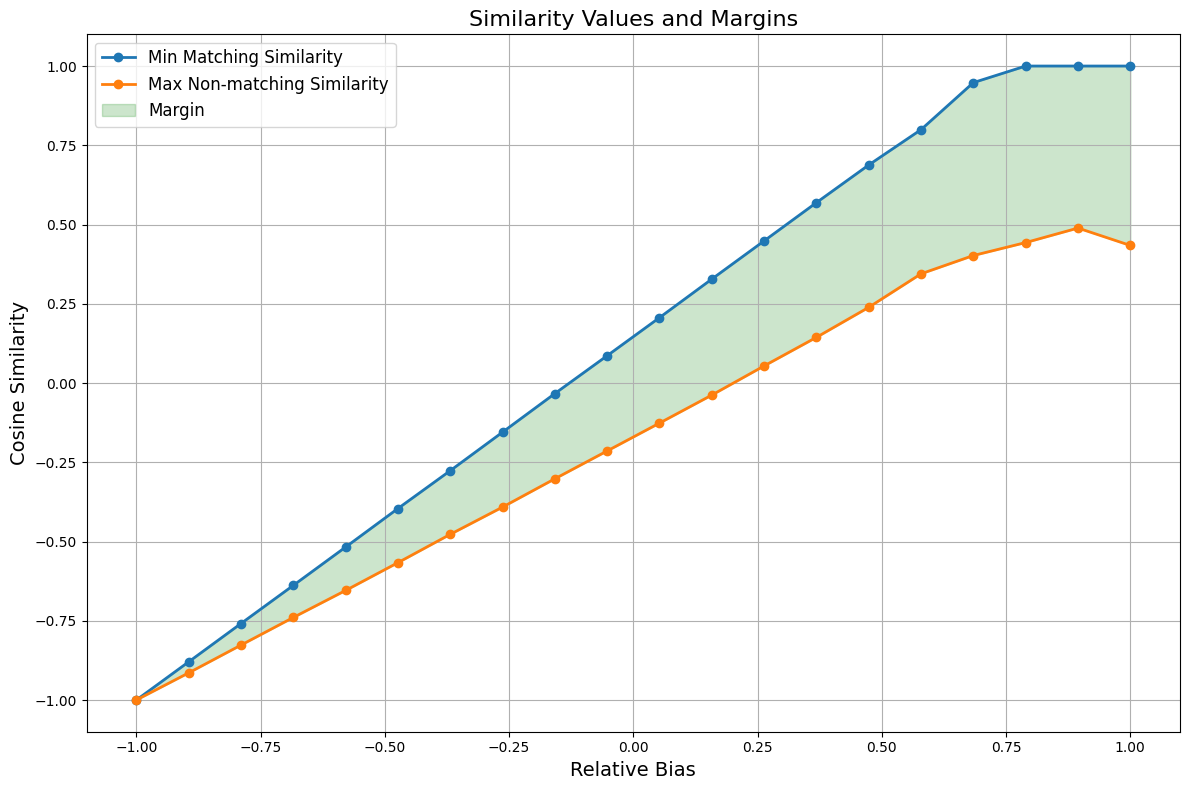


Script finished.


In [88]:
def main():
    torch.manual_seed(42)

    # Experiment parameters
    relative_biases_to_test = np.linspace(-1,1,20)
    n_classes = 100
    dim = 10
    n_epochs = int(1e4)
    initial_temperature = 10.0
    train_the_bias = False

    device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device_str}")
    print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
    print(f"Relative biases to test: {relative_biases_to_test}")

    all_experiment_results_tuples = [] # To store (U, V, criterion, losses)
    for i, rb_val in enumerate(relative_biases_to_test):
        print(f"\n--- Starting Experiment {i+1}/{len(relative_biases_to_test)} ---")
        print(f"Current Relative Bias: {rb_val}, Trainable Bias: {train_the_bias}, Temp: {initial_temperature}")
        experiment_runner = SigLIPExperiment(
            n_classes=n_classes,
            dim=dim,
            n_epochs=n_epochs,
            device=device_str
        )
        U_final, V_final, criterion_final, losses_history = experiment_runner.train(
            relative_bias=rb_val,
            temperature=initial_temperature,
            trainable_bias=train_the_bias
        )
        # Plot inner product gap for current experiment
        plt.figure(figsize=(10, 6))
        experiment_runner.plot_inner_product_gap(U_final, V_final)
        plt.title(f'Inner Product Distribution (rb={rb_val:.2f})')
        plt.close()  # Close to avoid displaying individual plots
        all_experiment_results_tuples.append((deepcopy(U_final), deepcopy(V_final), deepcopy(criterion_final), losses_history))
    print("\n--- All Experiments Complete. Analyzing and Plotting Aggregate Results. ---")
    experiment_runner.analyze_results(
        all_results=all_experiment_results_tuples,
        relative_biases=relative_biases_to_test,
    )
    print("\nScript finished.")

if __name__ == "__main__":
    main()